In [161]:
import json
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple, Optional

from collections import defaultdict
import time

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [181]:
import utils
import data_generation
import evaluation
import patching

Using device: cuda


In [163]:
# Model configurations
MODELS = {
    # # Llama models
    "Llama-3.2-1B-Instruct": "meta-llama/Llama-3.2-1B-Instruct",
    "Llama-3.1-8B-Instruct": "meta-llama/Llama-3.1-8B-Instruct",
    "Llama-3.3-70B-Instruct": "meta-llama/Llama-3.3-70B-Instruct",
    # # Qwen models
    "Qwen2.5-1.5B-Instruct": "Qwen/Qwen2.5-1.5B-Instruct",
    "Qwen2.5-7B-Instruct": "Qwen/Qwen2.5-7B-Instruct",
    "Qwen2.5-72B-Instruct": "Qwen/Qwen2.5-72B-Instruct",
}

In [164]:
# Load data
datasets = {}
for split in ["test"]:
    filepath = os.path.join(f"./data/{split}.json")
    with open(filepath, 'r') as f:
        datasets[split] = json.load(f)
    print(f"Loaded {len(datasets[split])} examples from {split} set")

Loaded 2000 examples from test set


# Generate dataset

In [ ]:
import data_generation

In [ ]:
TRAIN_CATEGORIES = {
    'clothing': ['shirt', 'pants', 'dress', 'jeans', 'coat', 'blazer', 'bikini', 'sweater', 'cardigen',
                 'jacket', 'skirt', 'vest', 'suit', 'blouse', 'pajama', 'underwear'],
    'animal': ['dog', 'cat', 'bird', 'fish', 'lion', 'tiger', 'wolf', 
               'fox', 'deer', 'cow', 'pig', 'sheep', 'goat'],
    'color': ['red', 'blue', 'green', 'yellow', 'black', 'white', 'pink', 
              'purple', 'brown', ],
    'body part': ['hand', 'leg', 'ear', 'eye', 'nose', 'mouth', 'arm', 'foot']
}

# Distractor words 
DISTRACTORS = [
    'book', 'paper', 'stone', 'metal', 'plastic', 'rubber',
    'string', 'wire', 'box', 'bag', 'cup', 'plate', 'pot', 'pan',
    'clock', 'phone', 'computer', 'screen', 'keyboard', 'camera',
    'music', 'sound', 'voice', 'word', 'letter', 'number', 'symbol', 'sign',
    'door', 'window', 'wall', 'floor', 'roof', 'stairs', 'path', 'road',
    'water', 'fire', 'air', 'wind', 'rain', 'ice',
    'space', 'time', 'day', 'night', 'morning'
]

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.3-70B-Instruct")
TRAIN_CATEGORIES = data_generation.verify_single_tokens(tokenizer, TRAIN_CATEGORIES)
DISTRACTORS = data_generation.verify_single_tokens(tokenizer, DISTRACTORS)

tokenizer = AutoTokenizer.from_pretrained("gpt2")
TRAIN_CATEGORIES = data_generation.verify_single_tokens(tokenizer, TRAIN_CATEGORIES)
DISTRACTORS = data_generation.verify_single_tokens(tokenizer, DISTRACTORS)

In [ ]:
print("train categories:")
for category, words in TRAIN_CATEGORIES.items():
    print(category, len(words))

"distractors: ", len(DISTRACTORS)

In [ ]:
# Create output directory
os.makedirs('data', exist_ok=True)
print(f"Train categories: {list(TRAIN_CATEGORIES.keys())}")

# Generate in-distribution test set
test_examples = data_generation.generate_dataset_split(
    TRAIN_CATEGORIES, DISTRACTORS, 
    num_examples=2000, split_name='test'
)

In [ ]:
# Analyze datasets
data_generation.analyze_dataset(test_examples, 'test')

In [ ]:
# Save data
with open("./data/test.json", 'w') as f:
    json.dump(test_examples, f, indent=2)

# Model evaluation

In [7]:
def evaluate_model(model_name):
    print(f"Loading model: {model_name}...")
    model, tokenizer = utils.load_model(MODELS[model_name])

    try:
        for dataset_split in ['test']:
            print(f"Evaluating on dataset: {dataset_split}")
            results = evaluate_dataset(model_name, dataset_split, model, tokenizer, datasets[dataset_split])
    
            # save results
            filename = f"eval_results_{model_name}_{dataset_split}.json"
            os.makedirs("./results", exist_ok=True)
            filepath = os.path.join("./results", filename)
            with open(filepath, 'w') as f:
                json.dump(results, f, indent=2)
    
            # print some results
            print(f"\n{model_name} Results:")
            print(f"  Accuracy: {results['accuracy']:.2%}")
            print(f"  Correct: {results['correct']}/{results['total']}")
            print(f"  Avg response time: {results['avg_response_time']:.2f}s")
            
    finally: # Clean up
        del model, tokenizer
        torch.cuda.empty_cache()
        gc.collect()

for model_name in MODELS.keys():
    results = evaluate_model(model_name)

Loading model: Llama-3.2-1B-Instruct...
Evaluating on dataset: test


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.37it/s]



Llama-3.2-1B-Instruct Results:
  Accuracy: 33.58%
  Correct: 1343/4000
  Avg response time: 0.15s
Loading model: Llama-3.1-8B-Instruct...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating on dataset: test


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Evaluating: 100%|██████████| 125/125 [01:01<00:00,  2.04it/s]



Llama-3.1-8B-Instruct Results:
  Accuracy: 70.05%
  Correct: 2802/4000
  Avg response time: 0.49s
Loading model: Llama-3.3-70B-Instruct...


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating on dataset: test


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Evaluating: 100%|██████████| 125/125 [09:32<00:00,  4.58s/it]



Llama-3.3-70B-Instruct Results:
  Accuracy: 90.60%
  Correct: 3624/4000
  Avg response time: 4.57s
Loading model: Qwen2.5-1.5B-Instruct...


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Evaluating on dataset: test


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:651: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`


Qwen2.5-1.5B-Instruct Results:
  Accuracy: 27.68%
  Correct: 1107/4000
  Avg response time: 0.23s
Loading model: Qwen2.5-7B-Instruct...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating on dataset: test


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:651: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`


Qwen2.5-7B-Instruct Results:
  Accuracy: 70.23%
  Correct: 2809/4000
  Avg response time: 0.45s
Loading model: Qwen2.5-72B-Instruct...


Loading checkpoint shards:   0%|          | 0/37 [00:00<?, ?it/s]

Evaluating on dataset: test


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/zy2559/.conda/envs/torch211/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:651: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`


Qwen2.5-72B-Instruct Results:
  Accuracy: 78.45%
  Correct: 3138/4000
  Avg response time: 4.63s


### analyze results

In [8]:
# read all results
all_results = {}
for model_name in MODELS.keys():
    filename = f"eval_results_{model_name}_test.json"
    filepath = os.path.join("./results", filename)
    with open(filepath, 'r') as f:
        result = json.load(f)
        all_results[model_name] = result

In [9]:
all_results.keys()

dict_keys(['Llama-3.2-1B-Instruct', 'Llama-3.1-8B-Instruct', 'Llama-3.3-70B-Instruct', 'Qwen2.5-1.5B-Instruct', 'Qwen2.5-7B-Instruct', 'Qwen2.5-72B-Instruct'])

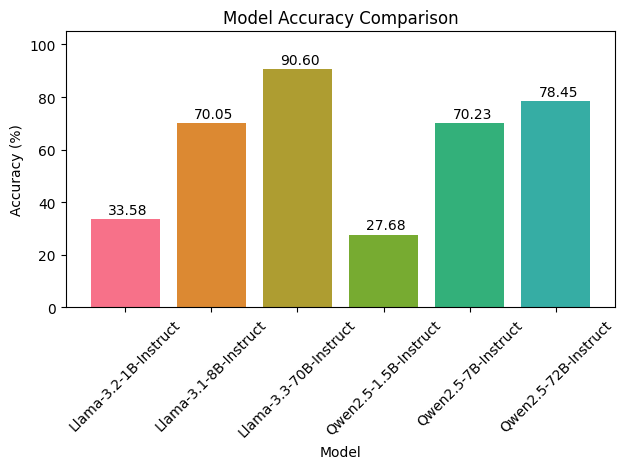

In [11]:
colors = sns.color_palette("husl", 10)

# Extract data
models = []
accuracies = []
response_times = []

for model_name, result in all_results.items():
    if "error" not in result:
        models.append(model_name)
        accuracies.append(result['accuracy'] * 100)
        response_times.append(result['avg_response_time'])

for i in range(len(models)):
    plt.text(i-0.2, accuracies[i]+2, "%.2f" % (accuracies[i])) 

# Accuracy plot
bars1 = plt.bar(models, accuracies, color=colors[:len(models)])
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 105)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

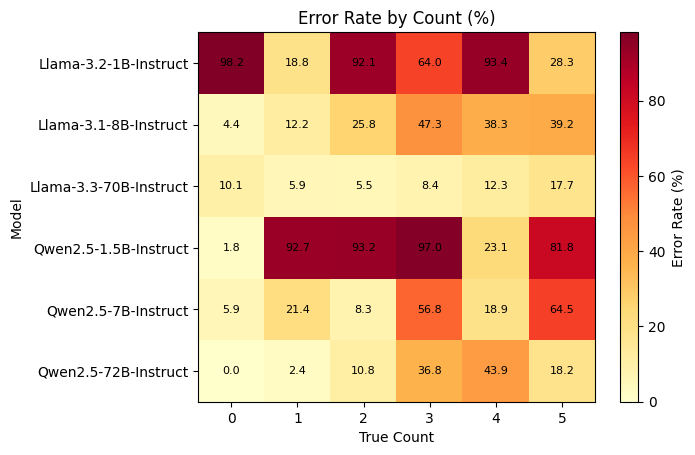

In [14]:
error_matrix = []
model_names = []

for model_name, result in all_results.items():
    model_names.append(model_name)
    errors_by_count = result.get('errors_by_count', {})
    
    # Create error rate array for counts 0-6
    error_rates = []
    for count in range(6):
        total_with_count = len([p for p in result['predictions'] 
                                  if p['true'] == int(count)])
        if total_with_count > 0 and str(count) in errors_by_count:
            # Calculate error rate for this count
            error_rate = errors_by_count[str(count)]['total'] / total_with_count
        else:
            error_rate = 0
        error_rates.append(error_rate * 100)
    error_matrix.append(error_rates)

im = plt.imshow(error_matrix, cmap='YlOrRd', aspect='auto')
plt.xticks(range(6))
plt.yticks(range(len(model_names)), labels=model_names)
plt.xlabel('True Count')
plt.ylabel('Model')
plt.title('Error Rate by Count (%)')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Error Rate (%)')

# Add text annotations
for i in range(len(model_names)):
    for j in range(6):
        text = plt.text(j, i, f'{error_matrix[i][j]:.1f}',
                     ha="center", va="center", color="black", fontsize=8)

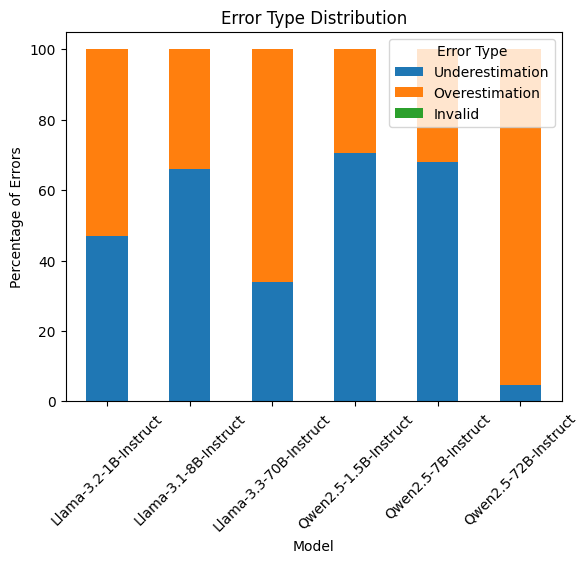

In [15]:
error_types_data = []
for model_name, result in all_results.items():
    analysis = result['error_analysis']
    error_types_data.append({
        'Model': model_name,
        'Underestimation': analysis.get('underestimation_rate', 0) * 100,
        'Overestimation': analysis.get('overestimation_rate', 0) * 100,
        'Invalid': (analysis.get('invalid_responses', 0) / 
                  analysis.get('total_errors', 1)) * 100
    })

df = pd.DataFrame(error_types_data)
df.set_index('Model')[['Underestimation', 'Overestimation', 'Invalid']].plot(
    kind='bar', stacked=True
)
plt.xlabel('Model')
plt.ylabel('Percentage of Errors')
plt.title('Error Type Distribution')
plt.legend(title='Error Type')
plt.xticks(label=df['Model'], rotation=45)

plt.show()

(array([0, 1, 2, 3]),
 [Text(0, 0, 'animal'),
  Text(1, 0, 'body part'),
  Text(2, 0, 'clothing'),
  Text(3, 0, 'color')])

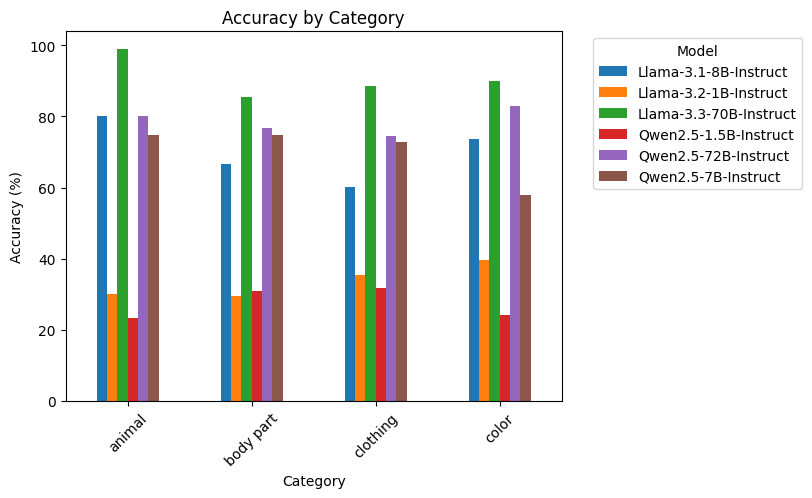

In [18]:
category_accuracy_data = []
        
for model_name, result in all_results.items():
    # Calculate accuracy by category
    errors_by_cat = result.get('errors_by_category', {})
    categories = set()
    
    # Get all categories from predictions
    for pred in result.get('predictions', []):
        categories.add(pred['category'])
    
    for cat in categories:
        total_cat = len([p for p in result.get('predictions', []) 
                       if p['category'] == cat])
        if total_cat > 0:
            errors = errors_by_cat.get(cat, 0)
            accuracy = (1 - errors / total_cat) * 100
            category_accuracy_data.append({
                'Model': model_name,
                'Category': cat,
                'Accuracy': accuracy
            })

df = pd.DataFrame(category_accuracy_data)
pivot_df = df.pivot(index='Category', columns='Model', values='Accuracy')
pivot_df.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Category')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(label=pivot_df.index, rotation=45)

In [ ]:
# plot predicted count distribution
for i, (model_name, result) in enumerate(all_results.items()):
    predictions = result['predictions']
    pred_counts = {}
    for p in predictions:
        if p['predicted'] in pred_counts:
            pred_counts[p['predicted']] += 1
        else:
            pred_counts[p['predicted']] = 1
    predictions_list = []
    counts_list = []
    for key in sorted(pred_counts.keys()):
        predictions_list.append(key)
        counts_list.append(pred_counts[key])
    plt.bar(predictions_list, counts_list)  
    plt.title(model_name)
    plt.show()

# Activation Patching

In [5]:
import patching

In [6]:
import importlib
importlib.reload(utils)
importlib.reload(patching)

<module 'patching' from '/engram/nklab/zy2559/activation_patching/patching.py'>

### run exp

In [21]:
dataset = datasets['test']
num_samples = 300

In [22]:
# select samples where the models are correct on both clean and corrupted runs
eval_results = {}
for model_name in MODELS.keys():
    filename = f"eval_results_{model_name}_test.json"
    filepath = os.path.join("./results", filename)
    with open(filepath, 'r') as f:
        result = json.load(f)
        eval_results[model_name] = result

selected_indices = []
model_name_1 = "Llama-3.3-70B-Instruct"
model_name_2 = "Llama-3.1-8B-Instruct"
for i in range(len(dataset)):
    clean_correct_1 = eval_results[model_name_1]['predictions'][i*2]['true'] == eval_results[model_name_1]['predictions'][i*2]['predicted']
    corrupted_correct_1 = eval_results[model_name_1]['predictions'][i*2+1]['true'] == eval_results[model_name_1]['predictions'][i*2+1]['predicted']
    clean_correct_2 = eval_results[model_name_2]['predictions'][i*2]['true'] == eval_results[model_name_2]['predictions'][i*2]['predicted']
    corrupted_correct_2 = eval_results[model_name_2]['predictions'][i*2+1]['true'] == eval_results[model_name_2]['predictions'][i*2+1]['predicted']
    
    if clean_correct_1 and corrupted_correct_1 and clean_correct_2 and corrupted_correct_2:
        selected_indices.append(i)

len(selected_indices)

989

In [23]:
# Load model
# position_option: "list_only", "list_and_after", "all", or "key_positions"
position_option = 'list_and_after'
model_name = "Llama-3.3-70B-Instruct"
# model_name = "Llama-3.1-8B-Instruct"

print("Loading model and tokenizer...")
model, tokenizer = utils.load_model(MODELS[model_name])

Loading model and tokenizer...


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [25]:
selected_indices_53 = []
for i in selected_indices:
    if dataset[i]['list_length'] == 5 and dataset[i]['corrupted_position'] == 2:
        selected_indices_53.append(i)

In [26]:
n_layers = model.config.num_hidden_layers
max_layers = n_layers
print(f"Testing {max_layers} layers\n")

Testing 80 layers



In [157]:
# Take subset of samples
# selected_samples = np.arange(num_samples)
selected_indices = selected_indices_53

results = []
for i, sample_id in enumerate(selected_indices):
    print(f"\n=== Sample {i+1}/{len(selected_indices)} ===")
    sample = dataset[sample_id]
    
    sample_results = patching.run_systematic_patching_by_position(
        model, tokenizer, sample, max_layers, position_option
    )
    results.append(sample_results)
    
    # Clear cache between samples
    torch.cuda.empty_cache()
    gc.collect()


=== Sample 1/21 ===
Processing sample test_000006 (body part)
Clean: 5, Corrupted: 4
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 2/21 ===
Processing sample test_000090 (color)
Clean: 0, Corrupted: 1
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 3/21 ===
Processing sample test_000129 (clothing)
Clean: 5, Corrupted: 4
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 4/21 ===
Processing sample test_000144 (color)
Clean: 1, Corrupted: 0
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 5/21 ===
Processing sample test_000171 (animal)
Clean: 2, Corrupted: 3
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 6/21 ===
Processing sample test_000323 (animal)
Clean: 0, Corrupted: 1
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 7/21 ===
Processing sample test_000372 (color)
Clean: 0, Corrupted: 1
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 8/21 ===
Processing sample test_000502 (clothing)
Clean: 4, Corrupted: 3
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 9/21 ===
Processing sample test_000503 (color)
Clean: 3, Corrupted: 2
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 10/21 ===
Processing sample test_000506 (animal)
Clean: 0, Corrupted: 1
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 11/21 ===
Processing sample test_000657 (clothing)
Clean: 3, Corrupted: 2
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 12/21 ===
Processing sample test_000661 (clothing)
Clean: 5, Corrupted: 4
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 13/21 ===
Processing sample test_000706 (animal)
Clean: 1, Corrupted: 2
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 14/21 ===
Processing sample test_000712 (animal)
Clean: 1, Corrupted: 2
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 15/21 ===
Processing sample test_000909 (clothing)
Clean: 0, Corrupted: 1
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 16/21 ===
Processing sample test_001127 (animal)
Clean: 2, Corrupted: 1
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 17/21 ===
Processing sample test_001145 (clothing)
Clean: 3, Corrupted: 2
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 18/21 ===
Processing sample test_001602 (animal)
Clean: 5, Corrupted: 4
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 19/21 ===
Processing sample test_001603 (animal)
Clean: 2, Corrupted: 1
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 20/21 ===
Processing sample test_001627 (animal)
Clean: 4, Corrupted: 3
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...



=== Sample 21/21 ===
Processing sample test_001738 (color)
Clean: 3, Corrupted: 4
Testing 9 token positions across 32 layers
  Testing residual...


  Testing attn...


  Testing mlp...


In [159]:
# Save complete results as pickle 
import pickle
pickle_path = os.path.join(f"./results/ap_results_53_{model_name}.pkl")
with open(pickle_path, 'wb') as f:
    pickle.dump(results, f)

## analyze results

In [156]:
model_name = "Llama-3.3-70B-Instruct"
# model_name = "Llama-3.1-8B-Instruct"

In [158]:
# Load results
import pickle
pickle_path = os.path.join(f"./results/ap_results_53_{model_name}.pkl")
with open(pickle_path, 'rb') as f:
    results = pickle.load(f)

In [165]:
dataset = datasets['test']
num_samples = 300

### single sample analysis

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional

def plot_single_sample_heatmap_vertical(sample_result: Dict,
                                 figsize: tuple = (9, 15), 
                                 vmin: float = -0.5,
                                 vmax: float = 0.5,
                                 show_values: bool = False,
                                 filter_layers: Optional[List[int]] = None,
                                 highlight_threshold: float = 0.1):

    # Extract data
    token_info = sample_result['token_info']
    test_positions = sample_result['test_positions']
    sample_info = sample_result['sample_info']

    components = ['residual', 'attn', 'mlp']
    component_names = ['Residual Stream', 'Attention Layer', 'MLP Layer']

    # Get layer range
    all_layers = set()
    for comp in components:
        if comp in sample_result:
            all_layers.update(sample_result[comp].keys())

    if filter_layers is not None:
        layers = [l for l in sorted(all_layers) if l in filter_layers]
    else:
        layers = sorted(all_layers)

    if not layers:
        print("No layers found in results!")
        return

    # Create figure with subplots for each component (3 rows, 1 column)
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Create position labels with token information
    position_labels = []
    for pos in test_positions:
        if pos < len(token_info['token_strings']):
            token_str = token_info['token_strings'][pos]
            # Clean and truncate token string
            token_str = token_str.strip().replace('\n', '\\n')
            if len(token_str) > 8:
                token_str = token_str[:8] + "..."

            # Add position type indicator
            pos_type = ""
            if pos in token_info.get('word_positions', []):
                word_idx = token_info['word_positions'].index(pos)
                pos_type = f"W{word_idx+1}"
            elif pos == token_info.get('list_end_position', -1) - 1:
                pos_type = "END"
            elif pos in token_info.get('list_positions', []):
                pos_type = "LST"

            label = f"{pos} {token_str} {pos_type}" if pos_type else f"{pos} {token_str}"
        else:
            label = str(pos)

        position_labels.append(label)

    # Plot each component
    for comp_idx, (component, comp_name) in enumerate(zip(components, component_names)):

        if component not in sample_result:
            axes[comp_idx].text(0.5, 0.5, f'No {component} data',
                                 ha='center', va='center', transform=axes[comp_idx].transAxes)
            axes[comp_idx].set_title(comp_name)
            continue

        # Create data matrix: positions x layers (transposed for plotting)
        data_matrix = np.zeros((len(test_positions), len(layers)))

        for pos_idx, pos in enumerate(test_positions):
            for layer_idx, layer in enumerate(layers):
                if layer in sample_result[component] and pos in sample_result[component][layer]:
                    data_matrix[pos_idx, layer_idx] = sample_result[component][layer][pos]
                else:
                    data_matrix[pos_idx, layer_idx] = 0.0

        # Create heatmap
        im = axes[comp_idx].imshow(data_matrix,
                                     cmap='RdBu_r',
                                     aspect='auto',
                                     vmin=vmin,
                                     vmax=vmax,
                                     interpolation='nearest')

        # Set labels and title
        axes[comp_idx].set_title(f'{comp_name}')
        axes[comp_idx].set_xlabel('Layer') # Layers on x-axis
        axes[comp_idx].set_ylabel('Token Position') # Positions on y-axis

        # Set ticks
        axes[comp_idx].set_xticks(range(len(layers)))
        axes[comp_idx].set_xticklabels(layers, rotation=45, ha='right', fontsize=8)
        axes[comp_idx].set_yticks(range(len(test_positions)))
        axes[comp_idx].set_yticklabels(position_labels)

        # Add value annotations if requested
        if show_values:
            for pos_idx in range(len(test_positions)):
                for layer_idx in range(len(layers)):
                    value = data_matrix[pos_idx, layer_idx]
                    if abs(value) > 0.01:  # Only show non-trivial values
                        color = 'white' if abs(value) > 0.3 else 'black'
                        axes[comp_idx].text(layer_idx, pos_idx, f'{value:.2f}', # Flipped coordinates
                                             ha='center', va='center',
                                             color=color, fontsize=6)

        # Highlight strong effects
        if highlight_threshold > 0:
            for pos_idx in range(len(test_positions)):
                for layer_idx in range(len(layers)):
                    value = data_matrix[pos_idx, layer_idx]
                    if abs(value) > highlight_threshold:
                        # Add border around strong effects (flipped coordinates)
                        rect = plt.Rectangle((layer_idx-0.4, pos_idx-0.4), 0.8, 0.8,
                                             fill=False, edgecolor='yellow', linewidth=2)
                        axes[comp_idx].add_patch(rect)

    # Add sample information
    info_text = (f"Sample: {sample_info['example_id']} | Category: {sample_info['category']}\n"
                 f"Clean count: {sample_info['clean_count']} | "
                 f"Corrupted count: {sample_info['corrupted_count']}")

    fig.suptitle(info_text, fontsize=12, y=0.95) # Adjusted y for suptitle

    # Apply tight_layout first, then adjust for colorbar
    plt.tight_layout(rect=[0, 0.03, 0.9, 0.95]) # Adjust rect to make space for suptitle and colorbar

    # Add colorbar to the right of the plots
    cbar_ax = fig.add_axes([0.92, 0.15, 0.025, 0.7]) # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax, label='Patching Effect (Normalized)', shrink=0.6)
    # plt.savefig(f"./figs/single_sample_heatmap_vertical_{sample_info['example_id']}.png", dpi=300, bbox_inches='tight')
    plt.show()

    return fig, axes

In [53]:
for i in range(21):
    positions = dataset[selected_indices_53[i]]['clean_target_positions']
    if 3 not in positions and 4 not in positions:
        print(i, dataset[selected_indices_53[i]])

1 {'category': 'color', 'list_length': 5, 'clean_prompt': 'Analyze the word list below. Count ONLY words that are color.\nFollow these rules:\n1. Strictly match the type definition (case-sensitive)\n2. Ignore non-word elements\n3. Output ONLY one interger count and nothing else\n\nType: color\nList: [string night number screen box]\nAnswer: ', 'clean_answer': '(0)', 'clean_target_count': 0, 'clean_word_list': ['string', 'night', 'number', 'screen', 'box'], 'clean_target_positions': [], 'corrupted_position': 2, 'corrupted_prompt': 'Analyze the word list below. Count ONLY words that are color.\nFollow these rules:\n1. Strictly match the type definition (case-sensitive)\n2. Ignore non-word elements\n3. Output ONLY one interger count and nothing else\n\nType: color\nList: [string night black screen box]\nAnswer: ', 'corrupted_answer': '(1)', 'corrupted_target_count': 1, 'corrupted_word_list': ['string', 'night', 'black', 'screen', 'box'], 'corrupted_target_positions': [2], 'split': 'test',

False
True


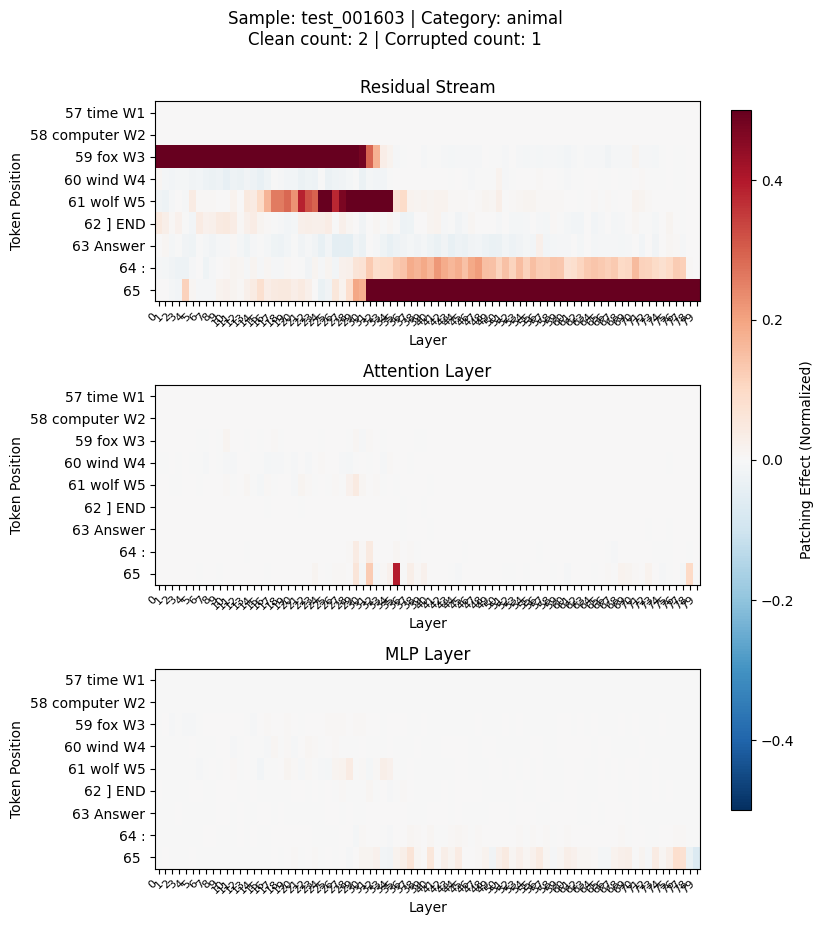

(<Figure size 800x1000 with 4 Axes>,
 array([<Axes: title={'center': 'Residual Stream'}, xlabel='Layer', ylabel='Token Position'>,
        <Axes: title={'center': 'Attention Layer'}, xlabel='Layer', ylabel='Token Position'>,
        <Axes: title={'center': 'MLP Layer'}, xlabel='Layer', ylabel='Token Position'>],
       dtype=object))

In [64]:
# results for llama 70B: 
# sample A: 15
# sample B: 18
# sample C: 16
# sample D: 2

i = 18
sample_result = results[i]
positions = dataset[selected_indices_53[i]]['clean_target_positions']
print(3 in positions)
print(4 in positions)
plot_single_sample_heatmap_vertical(sample_result,
                           figsize = (8, 10),
                          show_values=False,  # Show effect values in cells
                          highlight_threshold=5)  # Highlight strong effects

### aggregate samples

In [166]:
def get_key_token_positions_for_averaging(sample, sample_result) -> Dict[str, Optional[int]]:
    """
    Identifies token indices for key positions within a single sample_result.
    Assumes 'corrupted_position' in sample_info refers to the word index in a list 
    (e.g., 0-indexed for a list of 5 words, so 2 means the 3rd word).
    Key positions are defined relative to this corrupted word.
    """
    s_info = sample_result.get('sample_info', {})
    t_info = sample_result.get('token_info', {})
    
    word_token_indices = t_info.get('word_positions') # List of token indices for start of each word
    
    actual_test_positions = sample_result.get('test_positions', []) # Tokens for which effects exist
    actual_test_positions_sorted = sorted(list(set(actual_test_positions))) # Ensure sorted unique

    positions = {
        "corrupted_word": None,
        "post_corrupt_distractor": None,
        "post_corrupt_target": None,
        "second_last_token": None,
        "last_token": None
    }
    
    sample_id_for_log = s_info.get('example_id', 'N/A')

    if not actual_test_positions_sorted:
         print(f"Warning for {sample_id_for_log}: 'test_positions' is empty. Cannot determine last/second-last tokens or verify word positions.")
    
    corrupted_word_idx_in_list = sample.get('corrupted_position')

    if corrupted_word_idx_in_list is None:
         print(f"Warning for {sample_id_for_log}: 'corrupted_position' not in sample_info. Cannot identify word-based key positions.")
    elif not isinstance(word_token_indices, list) or not word_token_indices:
        print(f"Warning for {sample_id_for_log}: 'word_positions' is missing or not a list in token_info. Cannot identify word-based key positions.")
    else:
        # 1. Corrupted Word (e.g., word at index 2)
        if 0 <= corrupted_word_idx_in_list < len(word_token_indices):
            positions['corrupted_word'] = [word_token_indices[corrupted_word_idx_in_list]]
        else:
            print(f"Warning for {sample_id_for_log}: Corrupted word index {corrupted_word_idx_in_list} out of bounds for word_token_indices (len {len(word_token_indices)}).")

        # 2. Distractor after the corrupted word
        distractor_idx = [idx+actual_test_positions[0] for idx in [3,4] if idx not in sample['clean_target_positions']]
        positions['post_corrupt_distractor'] = distractor_idx

        # 3. Target after the corrupted word (word at corrupted_position + 2)
        # This assumes the list is long enough and this relative position is meaningful.
        target_after_idx = [idx+actual_test_positions[0] for idx in [3,4] if idx in sample['clean_target_positions']]
        positions['post_corrupt_target'] = target_after_idx

    # 4. last few tokens
    positions['forth_last_token'] = [actual_test_positions_sorted[-4]]
    positions['third_last_token'] = [actual_test_positions_sorted[-3]]
    positions['second_last_token'] = [actual_test_positions_sorted[-2]]
    positions['last_token'] = [actual_test_positions_sorted[-1]]

    return positions

In [179]:
def plot_average_key_position_residual_effects(
    sample_results: List[Dict],
    figsize: tuple = (10, 7), 
    vmin: Optional[float] = None, 
    vmax: Optional[float] = None,
    show_values: bool = True, 
    highlight_threshold: Optional[float] = None 
):
    """
    Calculates and plots the average 'residual' component effect over multiple samples
    for five key token positions. The plot is a heatmap with key positions 
    on the y-axis and layers on the x-axis.

    Args:
        sample_results: A list of sample_result dictionaries.
        figsize, vmin, vmax, show_values, highlight_threshold: Plotting parameters.
    """

    key_pos_display_names = { 
        "corrupted_word": "Corrupted Word",
        "post_corrupt_distractor": "Post-Corrupt Distractor",
        "post_corrupt_target": "Post-Corrupt Target",
        "forth_last_token": "] ",
        "third_last_token": "Answer",
        "second_last_token": ": ",
        "last_token": " "
    }
    key_pos_internal_names = list(key_pos_display_names.keys())
    
    if not sample_results:
        print("No sample_results provided.")
        return None, None
        
    all_layers_set = set()
    # Ensure 'residual' exists and is a dict before trying to get keys
    valid_samples_for_layer_scan = [
        sr for sr in sample_results if isinstance(sr.get('residual'), dict)
    ]
    if not valid_samples_for_layer_scan:
        print("No 'residual' data (or not in dict format) found in any sample_results.")
        return None, None

    for sr in valid_samples_for_layer_scan:
        all_layers_set.update(sr['residual'].keys())
    
    if not all_layers_set:
        print("No layers found in residual data across all samples.")
        return None, None
    layers = sorted(list(all_layers_set))

    aggregated_effects = {
        key_name: {layer: [] for layer in layers} for key_name in key_pos_internal_names
    }
    token_counts = {key_name: 0 for key_name in key_pos_internal_names}

    num_samples_contributing = 0
    for i, sample_result in enumerate(sample_results):
        s_info = sample_result.get('sample_info', {})
        sample_id_for_log = s_info.get('example_id', f"Sample_{i}")

        if not isinstance(sample_result.get('residual'), dict):
            print(f"Skipping {sample_id_for_log}: 'residual' data missing or not a dictionary.")
            continue
        # Other checks for token_info, test_positions are implicitly handled by get_key_token_positions_for_averaging

        key_token_indices_for_sample = get_key_token_positions_for_averaging(dataset[selected_indices_53[i]], sample_result)
        # key_token_indices_for_sample = get_key_token_positions_for_averaging(dataset[selected_indices[i]], sample_result)
        
        residual_data = sample_result['residual'] # Known to be a dict here
        # residual_data = sample_result['attn']
        sample_contributed_to_this_round = False

        for key_name in key_pos_internal_names:
            token_idx_list = key_token_indices_for_sample.get(key_name)
            for token_idx in token_idx_list:
                token_counts[key_name] += 1
                for layer in layers:
                    # Ensure layer exists in this sample's residual data
                    layer_effects = residual_data.get(layer)
                    if token_idx is not None and isinstance(layer_effects, dict) and token_idx in layer_effects:
                        effect = layer_effects[token_idx]
                        aggregated_effects[key_name][layer].append(effect)
                        sample_contributed_to_this_round = True
                    else:
                        aggregated_effects[key_name][layer].append(np.nan)
        
        if sample_contributed_to_this_round:
            num_samples_contributing += 1 # Count if sample provided at least one valid effect
    
    if num_samples_contributing == 0:
        print("No samples contributed any valid effects to the aggregation.")
        # Create an empty plot or return early
        fig, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, "No data to display after aggregation.", ha='center', va='center')
        plt.show()
        return fig, ax

    average_effects_matrix = np.full((len(key_pos_internal_names), len(layers)), np.nan)

    for k_idx, key_name in enumerate(key_pos_internal_names):
        for l_idx, layer in enumerate(layers):
            effects_list = aggregated_effects[key_name][layer]
            if effects_list: 
                valid_effects = [e for e in effects_list if not np.isnan(e)]
                if valid_effects:
                    average_effects_matrix[k_idx, l_idx] = np.mean(valid_effects) 

    # Determine vmin and vmax for color scaling
    effective_vmin, effective_vmax = vmin, vmax # Preserve user inputs


    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(average_effects_matrix,
                   cmap='RdBu_r',
                   aspect='auto',
                   vmin=effective_vmin,
                   vmax=effective_vmax,
                   interpolation='nearest')

    ax.set_title(f'Average Effect at Residual Stream (N={num_samples_contributing} samples)')
    ax.set_xlabel('Layer')
    ax.set_ylabel('Key Token Position')

    ax.set_xticks(np.arange(len(layers)))
    ax.set_xticklabels(layers, rotation=45, ha='right', fontsize=9)
    ax.set_yticks(np.arange(len(key_pos_internal_names)))
    ax.set_yticklabels([key_pos_display_names[name]+f", (N={token_counts[name]})" for name in key_pos_internal_names], fontsize=9)

    if show_values:
        for r_idx in range(len(key_pos_internal_names)):
            for c_idx in range(len(layers)):
                value = average_effects_matrix[r_idx, c_idx]
                if not np.isnan(value):
                    mid_val = (effective_vmax + effective_vmin) / 2.0
                    val_range = effective_vmax - effective_vmin
                    text_color = 'black' 
                    if val_range != 0: 
                        if abs(value - mid_val) > val_range * 0.35: 
                            text_color = 'white'
                    elif abs(value) > 0.5 : 
                         text_color = 'white'

                    ax.text(c_idx, r_idx, f'{value:.2f}',
                            ha='center', va='center',
                            color=text_color, fontsize=7)

    if highlight_threshold is not None and highlight_threshold > 0:
        for r_idx in range(len(key_pos_internal_names)):
            for c_idx in range(len(layers)):
                value = average_effects_matrix[r_idx, c_idx]
                if not np.isnan(value) and abs(value) > highlight_threshold:
                    rect = plt.Rectangle((c_idx - 0.5, r_idx - 0.5), 1, 1,
                                           fill=False, edgecolor='yellow', linewidth=1.5)
                    ax.add_patch(rect)
    
    fig.colorbar(im, ax=ax, label='Average Patching Effect (Normalized)', shrink=0.9)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    # plt.savefig("./figs/average_residual.png", dpi=300)
    plt.show()

    return fig, ax

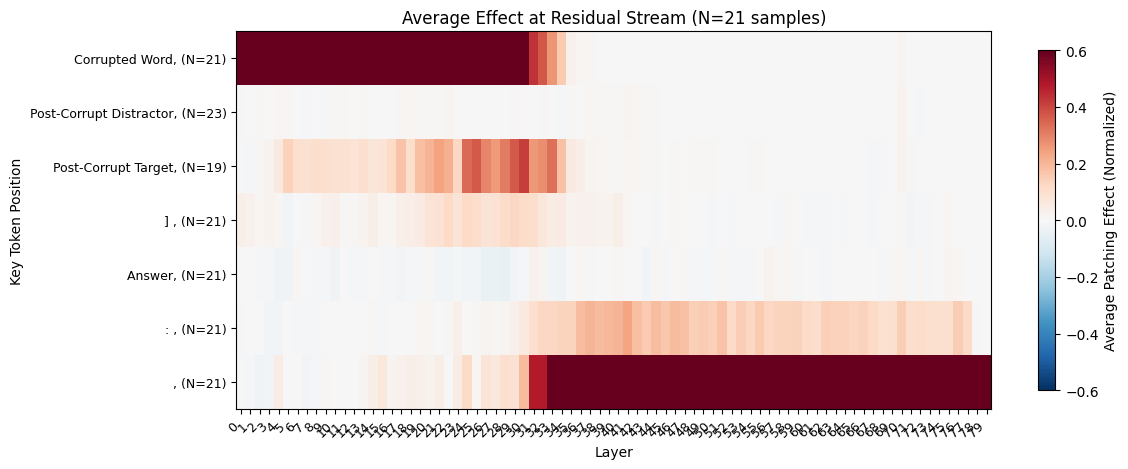

(<Figure size 1200x500 with 2 Axes>,
 <Axes: title={'center': 'Average Effect at Residual Stream (N=21 samples)'}, xlabel='Layer', ylabel='Key Token Position'>)

In [180]:
# Plot the average effects using the new function
plot_average_key_position_residual_effects(results, figsize = (12, 5), 
                                           vmin=-0.6, vmax=0.6, show_values=False, highlight_threshold=10)